In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sys
import re
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from captum.attr import IntegratedGradients

from sklearn.model_selection import KFold

# import RNA

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
input1 = torch.load("/home/ec2-user/internship/modeling/testing/test1_ae_cnn/input1.pt")
labels = torch.load("/home/ec2-user/internship/modeling/testing/test1_ae_cnn/input_labels.pt")
input2 = torch.load("/home/ec2-user/internship/modeling/testing/test1_ae_cnn/padded_latent_features.pt")
input2 = torch.stack(input2)
input2 = input2.unsqueeze(1)

In [76]:
input2.shape

torch.Size([724300, 1, 133, 32])

In [6]:
class CustomDataset(Dataset):
    def __init__(self, input1, input2, labels):
        self.input1 = input1
        self.input2 = input2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            'input1': self.input1[idx],
            'input2': self.input2[idx],
            'label': self.labels[idx]
        }
        return sample


In [8]:
class TwoBranchCNNRegressor(nn.Module):
    def __init__(self, input_channels1, input_channels2, output_size):
        super(TwoBranchCNNRegressor, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels1, out_channels=32, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=4),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Dropout(0.5)
        )

        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels2, out_channels=16, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),  
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),  
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2), 
            nn.Dropout(0.6)  
        )

        self.fc_input_size = self.calculate_fc_input_size(input_channels1, 100, 4, input_channels2, 133, 32)
        self.fc = nn.Linear(self.fc_input_size, 64)

        self.output_layer = nn.Linear(64, output_size)

    def forward(self, x1, x2):
        x1 = self.branch1(x1)
    
        x2 = self.branch2(x2)
    
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
    
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        output = self.output_layer(x)
    
        return output

    def calculate_fc_input_size(self, in_channels1, height1, width1, in_channels2, height2, width2):
        input_data1 = torch.randn(1, in_channels1, height1, width1)
        input_data2 = torch.randn(1, in_channels2, height2, width2)
    
        output1 = self.branch1(input_data1)
        output2 = self.branch2(input_data2)
    
        output1_flat = output1.numel() / output1.shape[0]  
        output2_flat = output2.numel() / output2.shape[0]  
    
        return int(output1_flat + output2_flat) 

In [9]:
input_dataset = CustomDataset(input1=input1, input2=input2, labels=labels)
input_loader = DataLoader(input_dataset, batch_size=128, shuffle=True, drop_last=True)
    
###
model = torch.load('./p04_CNN_model_1.pt')
model.to(device)

TwoBranchCNNRegressor(
  (branch1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np


all_preds = []
all_labels = []

with torch.no_grad():
    for batch in input_loader:
        input1 = batch['input1'].to(device)
        input2 = batch['input2'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input1, input2)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for easier handling
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Assuming single output and single label for simplicity
predicted = all_preds.flatten()
true_labels = all_labels.flatten()

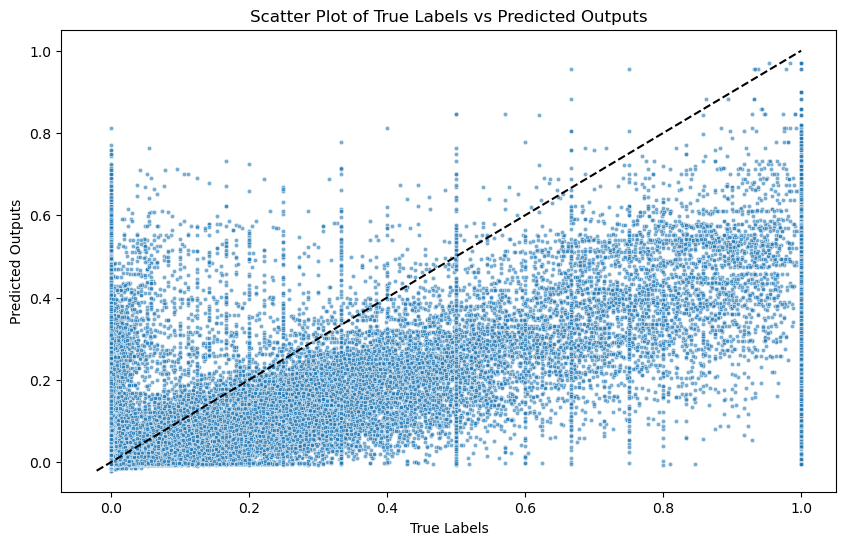

In [11]:
# Generate scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(true_labels, predicted, alpha=0.6, edgecolors='w', linewidth=0.5, s=10)
plt.xlabel('True Labels')
plt.ylabel('Predicted Outputs')
plt.title('Scatter Plot of True Labels vs Predicted Outputs')
min_val = min(true_labels.min(), predicted.min())
max_val = max(true_labels.max(), predicted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='x=y Line') 
plt.savefig("./test1_scatterplot.png")
plt.show()


In [13]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
r2 = r2_score(true_labels, predicted)

# Calculating correlation coefficient
correlation, _ = pearsonr(true_labels, predicted)
correlation1, _ = spearmanr(true_labels, predicted)

print("R^2:", r2)
print("Pearson correlation coefficient:", correlation)
print("Spearman correlation coefficient:", correlation1)

R^2: 0.5700185775505253
Pearson correlation coefficient: 0.7706071416419404
Spearman correlation coefficient: 0.33653508446860514


In [103]:
len(all_labels)

724224

In [15]:
# model.eval()

# input_loader = DataLoader(input_dataset, batch_size=256, shuffle=True, drop_last=True)

# N = 0
# for batch in input_loader:
#     X1 = batch['input1'].to(device)
#     X2 = batch['input2'].to(device)
#     y_edit = batch['label'].to(device)

#     ig = IntegratedGradients(model)
    
#     baseline = (torch.zeros_like(X1), torch.zeros_like(X2))
    
#     attributions, delta = ig.attribute((X1, X2), baseline, target=0, return_convergence_delta=True)
    
#     attributions_np1 = attributions[0].cpu().detach().numpy()
#     attributions_np2 = attributions[1].sum(dim=1).cpu().detach().numpy()
    
#     data1 = np.mean(attributions_np1, axis=0)
#     data2 = np.mean(attributions_np2, axis=0)
    
#     np.save('plot/p22_IG_input1_'+str(N)+'.npy', data1)
#     np.save('plot/p22_IG_input2_'+str(N)+'.npy', data2)
    
#     N = N + 1


KeyboardInterrupt: 

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# list_file = []
# for path, dirnames, filenames in os.walk('plot'):
#     list_file += filenames

# list_file = [i for i in list_file if 'p22_IG_input2' in i]
# lst1 = []
# lst2 = []
# for f in list_file:
#     d1 = np.load('plot/' + f.replace('input2', 'input1'))
#     d2 = np.load('plot/' + f)
#     lst1.append(d1)
#     lst2.append(d2)
#     break
# x = [i for i in range(0, 11) if i != 0]
# data1 = np.sum(lst1, axis=0)
# data2 = np.sum(lst2, axis=0)
# lst_x = [i for i in range(-31, 0)] + [i + 1 for i in range(10)]
# lst_col_color = ['#AFC4DC' for i in range(6)] + ['#FBC750' for i in range(25)] + ['#FB7072' for i in range(6)] + ['#AFC4DC' for i in range(4)]

# for N, v in enumerate(['Target', 'Spacer', 'Editing', 'C Region and PAM']):
#     data1_sub = data1[N]
#     df1_sub = pd.DataFrame(data1_sub, index=lst_x, columns=['A', 'C', 'G', 'T'])
#     df1_sub = df1_sub.loc[x]
#     plt.figure()
#     sns.clustermap(data=df1_sub, row_colors=lst_col_color, row_cluster=False, col_cluster=False,
#                    cmap='bwr', center=0, annot=True, fmt='.3f', figsize=(4, 6), linecolor='k',
#                    linewidth=0.5, dendrogram_ratio=0.05, cbar_pos=None, edgecolor='k',
#                    annot_kws={"size": 8, "color": "black"})
#     plt.title(v)
#     plt.savefig('plot/p23_clustermap_input1_'+v.replace(' ', '_')+'.png', bbox_inches='tight', dpi=300)
#     plt.savefig('plot/p23_clustermap_input1_'+v.replace(' ', '_')+'.pdf', bbox_inches='tight', dpi=300)
#     plt.show()
#     plt.close('all')
    
